In [1]:
import numpy as np
import cv2 as cv
from yunet import YuNet
import matplotlib.pyplot as plt
from PIL import Image

In [28]:
# Valid combinations of backends and targets
backend_target_pairs = [
    [cv.dnn.DNN_BACKEND_OPENCV, cv.dnn.DNN_TARGET_CPU],
    [cv.dnn.DNN_BACKEND_CUDA,   cv.dnn.DNN_TARGET_CUDA],
    [cv.dnn.DNN_BACKEND_CUDA,   cv.dnn.DNN_TARGET_CUDA_FP16],
    [cv.dnn.DNN_BACKEND_TIMVX,  cv.dnn.DNN_TARGET_NPU],
    [cv.dnn.DNN_BACKEND_CANN,   cv.dnn.DNN_TARGET_NPU]
]

class YuNetArgumentParser:
    def __init__(self, input=None, model='face_detection_yunet_2023mar_int8.onnx',
                 backend_target=0, conf_threshold=0.6, nms_threshold=0.1,
                 top_k=5000, save=False, vis=False):
        self.input = input
        self.model = model
        self.backend_target = backend_target
        self.conf_threshold = conf_threshold
        self.nms_threshold = nms_threshold
        self.top_k = top_k
        self.save = save
        self.vis = vis

args = YuNetArgumentParser(input="./images/group.jpg", save=True)

In [29]:
def visualize(image, results, names = [], box_color=(0, 255, 0), text_color=(0, 0, 255), fps=None):
    output = image.copy()
    landmark_color = [
        (255,   0,   0), # right eye
        (  0,   0, 255), # left eye
        (  0, 255,   0), # nose tip
        (255,   0, 255), # right mouth corner
        (  0, 255, 255)  # left mouth corner
    ]

    if fps is not None:
        cv.putText(output, 'FPS: {:.2f}'.format(fps), (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, text_color)

    output_faces = []

    for idx, det in enumerate(results):
        bbox = det[0:4].astype(np.int32)
        x, y, w, h = bbox
        cropped_img = output[y:y+h, x:x+w]
        cv.rectangle(output, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), box_color, 2)
        
        normalized_cropped_img = cropped_img / 255.0
        faces = cv.resize(normalized_cropped_img, (output.shape[1], output.shape[0]))
        output_faces.append(faces)

        conf = det[-1]  
        name = names[idx] if idx < len(names) else "Unknown"

        cv.putText(output, '{:.4f}'.format(conf), (bbox[0], bbox[1] + 12), cv.FONT_HERSHEY_DUPLEX, 0.5, text_color)
        cv.putText(output, name, (bbox[0], bbox[1] - 10), cv.FONT_HERSHEY_DUPLEX, 3, text_color)

        landmarks = det[4:14].astype(np.int32).reshape((5, 2))
        for lm_idx, landmark in enumerate(landmarks):
            cv.circle(output, landmark, 2, landmark_color[lm_idx], 2)

    return output, output_faces

backend_id = backend_target_pairs[args.backend_target][0]
target_id = backend_target_pairs[args.backend_target][1]

In [30]:
model = YuNet(modelPath=args.model,
              inputSize=[900, 900],
              confThreshold=args.conf_threshold,
              nmsThreshold=args.nms_threshold,
              topK=args.top_k,
              backendId=backend_id,
              targetId=target_id)

image = cv.imread(args.input)
print(image.shape)
h, w, _ = image.shape

model.setInputSize([w, h])
results = model.infer(image)

print('{} faces detected.'.format(results.shape[0]))
# for idx, det in enumerate(results):
#     print('{}: {:.0f} {:.0f} {:.0f} {:.0f} {:.0f} {:.0f} {:.0f} {:.0f} {:.0f} {:.0f} {:.0f} {:.0f} {:.0f} {:.0f}'.format(
#         idx, *det[:-1])
#     )

# Draw results on the input image
image, output_faces = visualize(image, results, ["prince"])

(2340, 4160, 3)
6 faces detected.


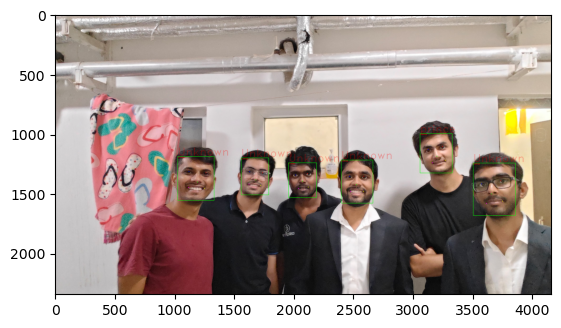

In [31]:
img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(img)

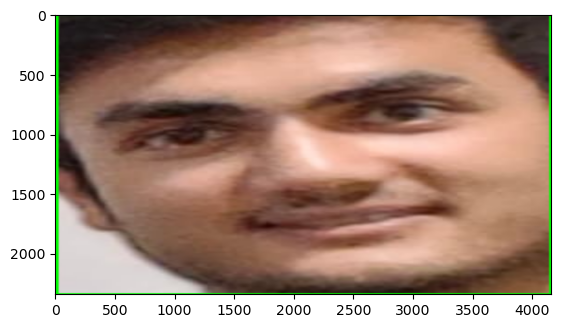

In [32]:
# Assuming out_img is a numpy array
out_img = (output_faces[0] * 255).astype(np.uint8)

# Now apply the color conversion
out_img = cv.cvtColor(out_img, cv.COLOR_BGR2RGB)

# Display the image
plt.imshow(out_img)


In [33]:
image_pil = Image.fromarray(out_img)
image_pil.save('pr.png')